# BatchNormalization(Application)

<img src="../../../picture/56.png" width=500 heigth="500">


由

$Z^{[l]}=W^{[l]}A^{[l-1]}$

**BN Forward:**

$\mu^{[l]}=\frac{1}{m}\sum_{i=1}^{m}Z^{[l](i)}$

${\sigma^{2}}^{[l]}=\frac{1}{m}\sum_{i=1}^{m}(Z^{[l](i)}-\mu^{[l]})$

$Z^{[l]}_{norm}=\frac{Z^{[l]}-\mu^{[l]}}{\sqrt{{\sigma^{2}}^{[l]}+\epsilon}}$

$\hat{Z}^{[l]}=\gamma^{[l]}\cdot Z^{[l]}_{norm}+\beta^{[l]}$

$\mu^{[l]}_{running} = \mu_{running} \cdot momentum + (1- momentum) \cdot \mu^{[l]} $

${\sigma^{2}}^{[l]}_{running} = {\sigma^{2}}^{[l]}_{running} \cdot momentum + (1- momentum) \cdot {\sigma^{2}}^{[l]}$

---------------

$A^{[l]}=g^{[l]}(\hat{Z}^{[l]})$

由

$d\hat{Z}^{[l]}=dA^{[l]}*g^{[l]^{'}}(\hat{Z}^{[l]})$

**BN Backward:**


$d\gamma^{[l]}=\sum_{i=1}^{m}d\hat{Z}^{[l](i)}\cdot Z^{[l](i)}_{norm} $

$d\beta^{[l]}=\sum_{i=1}^{m}d\hat{Z}^{[l](i)}$

$dZ^{[l](i)}_{norm}=d\hat{Z}^{[l](i)}\gamma^{[l]}$

$d\mu^{[l]}=\left ( \frac{-1}{\sqrt{\sigma^2+\epsilon}}\cdot\sum_{i=1}^{m}dZ^{[l](i)}_{norm} \right )$

$d{\sigma^{2}}^{[l]}=-0.5 \cdot (\sigma^2+\epsilon)^{-1.5}\cdot\sum_{i=1}^{m}dZ^{[l](i)}_{norm} (Z^{[l](i)}-\mu^{[l]})$

$dZ^{[l](i)}=\left(dZ^{[l](i)}_{norm}\cdot \frac{1}{\sqrt{\sigma^2+\epsilon}}\right) + \left(d\mu^{[l]}\cdot \frac{1}{m}\right) + \left(d{\sigma^{2}}^{[l]}\cdot \frac{2(Z^{[l](i)}-\mu)}{m} \right)$

-----------

**Update:**

$W,\gamma,\beta$

**BN Testing:**

<h3>$\hat{Z}^{[l]}= \gamma^{[l]}\cdot \frac{(Z^{[l]}-\mu^{[l]}_{running})}{\sqrt{{\sigma^{2}}^{[l]}_{running}+\epsilon}}+\beta^{[l]}$</h3>

---------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from data_utils import get_CIFAR10_data
from matplotlib import gridspec
from miniBatch import random_mini_batche
from DNN import MODEL,score_base

### Load Data

这里我们使用CIFAR10的数据集,由于数据量较多,我们取

训练样本:2000

验证样本:100

测试样本:100

In [2]:
# Load the (preprocessed) CIFAR10 data.
data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


In [3]:
def load_data(index_train,index_val,index_test):
    train_x = data['X_train'][:index_train].reshape(index_train,-1)
    train_y = data['y_train'][:index_train]
    
    val_x = data['X_val'][:index_val].reshape(index_val,-1)
    val_y = data['y_val'][:index_val]
    
    test_x = data['X_test'][:index_test].reshape(index_test,-1)
    test_y = data['y_test'][:index_test]
    
    return train_x,train_y,val_x,val_y,test_x,test_y

In [4]:
train_x,train_y,val_x,val_y,test_x,test_y = load_data(2000,100,100)

### Initialization Parameters

初始化L层网络中的weights:$W$,scale:$\gamma$,shift:$\beta$.

其中为了后面测试网络方便,

```is_small:```表示$W$初始值较大还是较小.

In [5]:
def init_parameters(n,layers,is_small):
    """
    Initialization Parameters 
    
    Parameters:
    ----------
       n: data features.
       layers: #NN Hidden layer units.
       is_small : weights small if true else bigger.
       
    Returns:
    -------
       parameters: initialize W,beta,gamma
       L: #layers,plus input layer.
    
    """
    layers.insert(0,n)
    L = len(layers)
    parameters = {}
    for l in range(1,L):
        if is_small:
            parameters['W'+str(l)] = np.random.randn(layers[l-1],layers[l]) / np.sqrt(layers[l-1])
        else:
            parameters['W'+str(l)] = np.random.randn(layers[l-1],layers[l])
        parameters['gamma'+str(l)] = np.ones((1,layers[l]))
        parameters['beta'+str(l)] = np.zeros((1,layers[l]))
    
    return parameters,L
    

### Build Activation Functions

(1) ReLu:ReLu 激活函数

(2) Softmax: softmax 激活函数

In [6]:
def relu(Z):
    """
    ReLu function
    """
    return np.maximum(0,Z)

In [7]:
def softmax(Z):
    """
    Softmax function
    """
    t = np.exp(Z)
    res = t / np.sum(t,axis=1,keepdims=True)  # feature axis
    return res

### Build Forward

构建网络的Forward,包含两部分:

(1) 普通层的Forward

```python 

def forward_with_bn(...):
    ...```

(2) BN层的Forward

```python

def bn_forward(...):
    ...```
    
(2.1) BN层需要记录running mean/ running var,用于在testing时使用.

(2.2) 变量```Z,eps,Z_mean,Z_var,Z_hat,Z_norm,gamma,beta```缓存,在Backward的时候使用.

(3) 网络构成:

input-->|caculate Z|-->|Z_hat=BN(Z,gamma,beta)|-->|A=Activation(Z_hat)|-->...-->output-->caculate loss.

In [8]:
def bn_forward(Z,gamma,beta,bn_param,l):
    """
    Build BN forward.
    
    Parameters:
    ----------
       Z: linear value in general layer.
       gamma: BN parameter scale.
       beta: BN parameter shift.
       bn_param: eps,momentum,running mean/running var
       l: l layer. total number L.
    
    Returns:
    -------
       Z_hat: BN layer output value equal next general layer input value to compute activation value.
       
       cache:
       ####################################################
       # Z: linear value in general layer                 #
       # eps: minimum value,prevent the var equal 0.      #
       # Z_mean:linear value mean.                        #
       # Z_var:linear value var.                          #
       # Z_norm: Normalization Z.                         #
       # Z_hat: BN linear: Z_hat = scale * normal + shift.#
       # gamma: scale,need update                         #
       # beta: shift,need update.                         #
       ####################################################
       
    Note:
        (1) we need cache running mean/running var, and using this in testing.
        (2) norm Z,normalization feature,so the axis euqal sample data axis.
    
    """
    eps = bn_param['eps']
    momentum = bn_param['momentum']
    m,n = Z.shape
    
    # get running mean/ running var, initialization zeros if first forwarding current layer.
    running_mean = bn_param.get('running_mean_'+str(l),np.zeros(n,dtype=Z.dtype))
    running_var = bn_param.get('running_var_'+str(l),np.zeros(n,dtype=Z.dtype))
    
    #######Core processing in BN forward part #####
    Z_mean = np.mean(Z,axis=0,keepdims=True)
    Z_var = np.var(Z,axis=0,keepdims=True)
    Z_norm = (Z-Z_mean) / np.sqrt(Z_var + eps)
    Z_hat = gamma * Z_norm + beta
    ################# end #######################

    # caculate running mean/running var
    running_mean = running_mean * momentum + (1- momentum) * Z_mean
    running_var = running_var * momentum + (1- momentum) * Z_var
    
    # cache running mean/running var in bn_param of current layer 
    bn_param['running_mean_'+str(l)] = running_mean
    bn_param['running_var_'+str(l)] = running_var

    cache = (Z,eps,Z_mean,Z_var,Z_hat,Z_norm,gamma,beta)
        
    return Z_hat,cache   

In [9]:
def forward_with_bn(X,parameters,L,bn_param):
    """
    Build forward propagation.
    
    Parameters:
    ----------
        X: data set in input layer
        parameters:W,gamma,beta
        L: #layers.
        bn_param:set eps and momentum
    Returns:
    -------
        A: output layer value. using sigmoid function.
        
        cache_BN_para:
        ###########################################################
        #   cache BN layer parameters,a dictionary:               #
        #   key:cache_bn_..                                       #
        #   value:(Z,eps,Z_mean,Z_var,Z_hat,Z_norm,gamma,beta)    #
        #   will using in BN backward propagation.                #
        ###########################################################    
        
        cache_Dn_para:
        ####################################################
        # Z:general layer output linear value.             #
        # Z_hat_: BN layer output.                         #
        # A: general layer activation value.               #
        # will using in general layer backward propagation.#
        ####################################################
        
        L:  #layers,plus input layer.
    """
    cache_BN_para = {}
    cache_Dn_para = {'A0':X}
    A = X
    for l in range(1,L):
        W = parameters['W'+str(l)]
        gamma = parameters['gamma'+str(l)]
        beta = parameters['beta'+str(l)]
        Z = np.dot(A,W) # general layer,calculate Z.
        Z_hat,cache_bn = bn_forward(Z,gamma,beta,bn_param,l) # using BN layer
        
        if l != L-1:
            A = relu(Z_hat)
        else:
            A = softmax(Z_hat) # output layer activation.
        
        # cache Z:linear value.
        # Z_hat_: BN layer output.
        # A:activation value.
        # cache_bn_: BN layer parameters.
        cache_Dn_para['Z'+str(l)] = Z
        cache_Dn_para['Z_hat_'+str(l)] = Z_hat
        cache_Dn_para['A'+str(l)] = A
        cache_BN_para['cache_bn_'+str(l)] = cache_bn
    
    return A,cache_BN_para,cache_Dn_para,L

### Build loss function

因为我们是使用的softmax,所以其损失函数如下:

$loss = \frac{1}{m}\sum_{i=1}^{m}y\cdot log{A}$

In [10]:
def cacl_loss(A,y):
    """
    caculate loss.
    
    Paraemters:
    ----------
       A: output layer value
       y: data true label
    Returns:
    -------
        loss: current loss.
    """
    m = y.shape[0]
    assert A.shape==y.shape # make sure the shape is true.
    loss = - np.sum(y*np.log(A))/m
    return loss

### Build Backward

同样构建网络的backward由两部分构成:

(1) 普通层的backward

```python

def backward_with_bn(...):
    ...```
    
(2) BN层的backward

```python
def bn_backword(...):
    ...```


(3) 网络构成:

loss -->|output:dA|-->|dA:dZ_hat|-->|dBN:dZ,dgamma,dbeta|-->|dZ:dW|

In [11]:
def bn_backword(dout,cache):
    """
    Build BN backward. 
    Parameters:
    ----------
        dout: BN layers output value.
        cache: forward BN layers cache param
    Returns:
    -------
        dZ: linear value of general layer output value.
        dgamma: Derivative gamma. 
        dbeta: derivative beta.
        
    Note:
    ----
        (1) we don't caculate running/mean/var,it's just using testing part.
        (2) axis: many sample control scale and beta,so  axis euqal sample data axis. 
    """
    (Z,eps,Z_mean,Z_var,Z_hat,Z_norm,gamma,beta) = cache
    m,n = Z.shape
    #######################Core processing in BN backward part  #####################
    dbeta = np.sum(dout,axis=0)
    dgamma = np.sum(np.multiply(dout,Z_norm),axis=0)
    dZ_norm = dout * gamma
    dZ_mean = -np.sum(dZ_norm,axis=0) /np.sqrt(Z_var + eps) 
    dZ_var = -0.5 * np.power((Z_var + eps),-1.5) * np.sum(dZ_norm * (Z-Z_mean),axis=0)
    
    dZ_1 = dZ_norm * (1./np.sqrt(Z_var+eps))
    dZ_2 = dZ_mean / m
    dZ_3 = dZ_var * (2 *(Z-Z_mean))/m
    
    dZ =dZ_1 + dZ_2 + dZ_3
    ##################################  end #########################################
    return dZ,dgamma,dbeta

In [12]:
def backward_with_bn(A,y,parameters,cache_BN_para,cache_Dn_para,L):
    """
    Build backward propagation 
    
    Parameters:
    ----------
        A: output layer value.
        y: data true 
        parameters: W,scale:gamma,shift:beta.
        cache_BN_para: cache BN parameters:Z,eps,Z_mean,Z_var,Z_hat,Z_norm,gamma,beta
        cache_Dn_para: cache general layer parameters:Z,Z_hat_,A
        L:#layers,plus input layer.
    Returns:
    -------
        dparameters: Updateing param: dgamma,dbeta,dW
        L:#layers,plus input layer.
    """
    
    m = y.shape[0]
    dparameters = {}
    
    dZ_hat = A - y # loss-->dZ_hat
    
    for l in range(L-1,0,-1):
        
        ########## BN layers backward ############
        cache = cache_BN_para['cache_bn_'+str(l)]
        dZ,dgamma,dbeta = bn_backword(dZ_hat,cache)
        ################ end #####################
        
        A = cache_Dn_para['A'+str(l-1)]
        
        dW = np.dot(A.T,dZ) /m
        
        # cache Updateing parameters.
        dparameters['dgamma'+str(l)] = dgamma
        dparameters['dbeta'+str(l)] = dbeta
        dparameters['dW'+str(l)] = dW
    
        if l == 1: # input layer break
            break
        else:
            ######### general layers backward ######
            W = parameters['W'+str(l)]
            dA = np.dot(dZ,W.T)
            Z = cache_Dn_para['Z'+str(l-1)]
            dZ_hat = dA * np.int64(Z>0.)
            ############ end #####################
        
    return dparameters,L

### Update

当反向传播完成之后,我们就可以开始更新参数

In [13]:
def update_with_bn(alpha,parameters,dparameters,L):
    """
    UPdating parameters
    
    Parameters:
    ----------
        alpha: learLearning rate.
        parameters: weights:W,scale:gamma,shift:beta
        dparameters: dW,dgamma,dbeta
        L:#layers plus input layer.
    
    Return:
    ------
        parameters: updated parameters.
    
    """
    for l in range(1,L):
        parameters['W'+str(l)] = parameters['W'+str(l)] - alpha * dparameters['dW'+str(l)]
        parameters['gamma'+str(l)] = parameters['gamma'+str(l)] - alpha * dparameters['dgamma'+str(l)]
        parameters['beta'+str(l)] = parameters['beta'+str(l)] - alpha * dparameters['dbeta'+str(l)]
    return parameters

### Score

构建一个正确率函数,用于在迭代过程中查看训练样本和验证样本的正确率走势.

这个函数实际上也是在使用BN的测试阶段,所以我们需要使用

running mean 来估计样本的均值.

running var 来估计样本的方差.

In [14]:
def score(X,y,L,bn_param,parameters):
    """
    Build score function
    Parameters:
    ----------
        X: score data.
        y: score data true labels.
        L: L:#layers plus input layer.
        bn_param: have finally running mean/ running var.and eps.
        parameters: have best weights W,scale:gamma,shift:beta.
    Return:
    ------
        accuracy: current data correct.
    """
    m,n = X.shape
    eps = bn_param['eps']
    
    A = X
    for l in range(1,L):
        W = parameters['W'+str(l)]
        Z = np.dot(A,W)
        running_mean = bn_param['running_mean_'+str(l)]
        running_var = bn_param['running_var_'+str(l)]
        gamma = parameters['gamma'+str(l)]
        beta = parameters['beta'+str(l)]
        
        # need using running mean and running var to caculate Z_hat.
        Z_hat = (Z-running_mean)*gamma / np.sqrt(running_var + eps) + beta
        if l != L-1:
            A = relu(Z_hat)
        else:
            A = softmax(Z_hat)
    
    accuracy = (np.argmax(A,axis=1)==y).sum() / m # caculate accuracy.
    
    return accuracy

### Build Model

当一切都准备完毕之后,我们就可以开始构建整体的模型.

模型流程:

(1) 使用mini-batch训练样本

(2) 进行Forward

(3) 计算Loss

(4) 进行Backward

(5) 更新参数

(6) 每隔100步缓存当前训练样本的loss,训练/验证样本的争取率

Note: ```is_small```用于控制初始化W是大小,方便后面对比的时候使用.

In [15]:
def model(X,y,X_val,y_val,epocs,layers,alpha,batch_size=64,eps=1e-5,momentum=0.99,is_small=True):
    
    """
    Build Model
    
    Parameters:
    ----------
        X: training data.
        y: training labels.
        X_val: Verification data.
        y_val: verification labels.
        epocs: #Iterative
        layers: NN layers: hidden layer plus output layer.
        alpha: learning rate.
        batch_size: batch data size in every epoch.
        eps: minimum value.prevent the var equal zero.
        momentum: running monentum value.
        is_small : weights value small if true else bigger.
        
    Returns:
    -------
        bn_param: BN layer parameter: eps,momentum,running mean/var.
        parameters: have best scale:gamma,shift:beta,weights:W
        L: L:#layers plus input layer.
        
        costs: cache loss at 10 step.
        cache_acc_train: cache train data accuracy at 10 step.
        cache_acc_val: cache verification data accuracy at 10 step.
    """
    m,n = X.shape
    classes = len(np.unique(y))
    parameters,L = init_parameters(n,layers,is_small) # Initialization parameters
    bn_param = {'eps':eps,'momentum':momentum}
    costs = []
    cache_acc_train = []
    cache_acc_val = []
    seed = 0
    num_minibatches  = X.shape[0] / batch_size
    
    # Start Iteration 
    for epoch in range(epocs):
        epoch_cost = 0
        seed = seed + 1  
        mini_batches = random_mini_batche(X,y,batch_size,seed) # use batch size to geting mini-batch
        for minibatch in mini_batches:
            
            (mini_batche_X,mini_batche_Y) = minibatch
            mini_batche_Y_hot = np.eye(classes)[mini_batche_Y] # change y to "hot y",very important.
            # start forward
            A,cache_BN_para,cache_Dn_para,L = forward_with_bn(mini_batche_X,parameters,L,bn_param)
            
            # caculate loss
            loss = cacl_loss(A,mini_batche_Y_hot)
            epoch_cost += loss / num_minibatches # caculate mean loss
            
            # start backward
            dparameters,L = backward_with_bn(A,mini_batche_Y_hot,parameters,cache_BN_para,cache_Dn_para,L)
            
            # start updating
            parameters = update_with_bn(alpha,parameters,dparameters,L)
            
        if epoch % 10 == 0:
            costs.append(epoch_cost)
            # calculate train accuracy
            accuracy_train = score(X,y,L,bn_param,parameters)
            cache_acc_train.append(accuracy_train)
            
            # calculate val data
            accuracy_val = score(X_val,y_val,L,bn_param,parameters)
            cache_acc_val.append(accuracy_val)
            
        if epoch % 100 == 0:
            print('After epoch:{} loss:{} train acc:{} val acc:{}'.format(epoch,
                                                                          epoch_cost,accuracy_train,accuracy_val))
            
        
    return bn_param,parameters,L,costs,cache_acc_train,cache_acc_val

### Testing BN and BaseLine

测试不同情况下,BN网络与普通网络之间的差异:

(1) 小权重,小学习率

(2) 小权重,大学习率

(3) 大权重,小学习率

(4) 大权重,大学习率

In [16]:
def plot_(costs_bn,costs,cache_acc_train_bn,cache_acc_train,cache_acc_val_bn,cache_acc_val):
    fig=plt.figure(figsize=(20,4))
    ax1=fig.add_subplot(1,3,1)      
    ax1.plot(costs_bn,c='orange',label='batch normal')
    ax1.plot(costs,label='base line')
    ax1.set_title('Loss:batch normal & base line')
    ax1.set_xlabel('#epoch')
    ax1.set_ylabel('Value')
    ax1.legend()

    ax2 =fig.add_subplot(1,3,2)      
    ax2.plot(cache_acc_train_bn,c='orange',label='batch normal')
    ax2.plot(cache_acc_train,label='base line')
    ax2.set_title('Train acc:batch normal & base line')
    ax2.set_xlabel('#epoch')
    ax2.set_ylabel('Value')
    ax2.legend()

    ax3 =fig.add_subplot(1,3,3)      
    ax3.plot(cache_acc_val_bn,c='orange',label='batch normal')
    ax3.plot(cache_acc_val,label='base line')
    ax3.set_title('Val acc:batch normal & base line')
    ax3.set_xlabel('#epoch')
    ax3.set_ylabel('Value')
    ax3.legend()

    plt.show()

#### 小权重,小学习率

In [17]:
bn_param,parameters_bn,L_bn,costs_bn,cache_acc_train_bn,cache_acc_val_bn = model(train_x,
                                                                  train_y,val_x,val_y,1000,
                                                                  [100, 80,50,30,10],0.001,batch_size=32)

After epoch:0 loss:2.538345916747788 train acc:0.189 val acc:0.13
After epoch:100 loss:0.27367399476795184 train acc:0.9855 val acc:0.33
After epoch:200 loss:0.12019307164023306 train acc:1.0 val acc:0.33
After epoch:300 loss:0.07955164724830621 train acc:1.0 val acc:0.29
After epoch:400 loss:0.05679991077760921 train acc:1.0 val acc:0.34
After epoch:500 loss:0.051644538522350375 train acc:1.0 val acc:0.38
After epoch:600 loss:0.030937442504173036 train acc:1.0 val acc:0.34
After epoch:700 loss:0.02798777184703676 train acc:1.0 val acc:0.34
After epoch:800 loss:0.03495028832997823 train acc:1.0 val acc:0.31
After epoch:900 loss:0.02324225842847714 train acc:1.0 val acc:0.34


In [18]:
parameters,costs, cache_acc_train, cache_acc_val,L = MODEL(train_x,train_y,
                                                           val_x,val_y,1000,
                                                         [100,80,50,30,10],0.001,batch_size=32)

After epoch:0 loss:19.791088010258296 train acc:0.1225 val acc:0.09
After epoch:100 loss:1.0068006665486509 train acc:0.721 val acc:0.12
After epoch:200 loss:0.5550247629456173 train acc:0.8765 val acc:0.12
After epoch:300 loss:0.3658199114969263 train acc:0.9325 val acc:0.13
After epoch:400 loss:0.26601446374493876 train acc:0.966 val acc:0.15
After epoch:500 loss:0.20331898845402563 train acc:0.9775 val acc:0.18
After epoch:600 loss:0.1594905694329738 train acc:0.9845 val acc:0.16
After epoch:700 loss:0.1319329099734257 train acc:0.988 val acc:0.16
After epoch:800 loss:0.11118191204671603 train acc:0.9905 val acc:0.16
After epoch:900 loss:0.09570714685722582 train acc:0.993 val acc:0.15


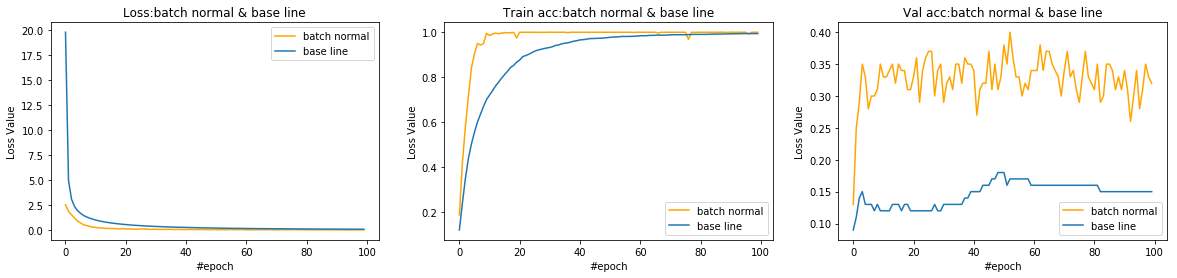

In [19]:
plot_(costs_bn,costs,cache_acc_train_bn,cache_acc_train,cache_acc_val_bn,cache_acc_val)

可以看到在小权重,小学习率的情况下,BaseLine,的各方面情况都不如BN优秀.

#### 小权重,大学习率

In [20]:
bn_param,parameters_bn,L_bn,costs_bn,cache_acc_train_bn,cache_acc_val_bn = model(train_x,
                                                                  train_y,val_x,val_y,1000,
                                                                  [100, 80,50,30,10],0.1,batch_size=60)

After epoch:0 loss:2.241129991207395 train acc:0.2365 val acc:0.2
After epoch:100 loss:0.13425242913739963 train acc:0.9015 val acc:0.39
After epoch:200 loss:0.05370672994350222 train acc:0.9955 val acc:0.39
After epoch:300 loss:0.01901921303726467 train acc:0.9985 val acc:0.41
After epoch:400 loss:0.019742989430538233 train acc:0.9995 val acc:0.35
After epoch:500 loss:0.015151633714413845 train acc:1.0 val acc:0.38
After epoch:600 loss:0.019477361294748155 train acc:0.998 val acc:0.36
After epoch:700 loss:0.008340593797426686 train acc:1.0 val acc:0.4
After epoch:800 loss:0.0093850647551786 train acc:1.0 val acc:0.4
After epoch:900 loss:0.012881295311387191 train acc:0.999 val acc:0.4


In [21]:
parameters,costs, cache_acc_train, cache_acc_val,L = MODEL(train_x,train_y,
                                                           val_x,val_y,1000,
                                                         [100,80,50,30,10],0.1,batch_size=60)

After epoch:0 loss:8.2782938712435 train acc:0.1355 val acc:0.1
After epoch:100 loss:0.2126304612343355 train acc:0.9295 val acc:0.33
After epoch:200 loss:0.05342738053328768 train acc:0.977 val acc:0.3
After epoch:300 loss:0.02829338706533281 train acc:0.9885 val acc:0.32
After epoch:400 loss:0.012209559291405077 train acc:0.9955 val acc:0.31
After epoch:500 loss:0.00932930017627778 train acc:0.9955 val acc:0.3
After epoch:600 loss:0.007737923322933606 train acc:0.996 val acc:0.31
After epoch:700 loss:0.005965315266091267 train acc:0.997 val acc:0.31
After epoch:800 loss:0.005188986889630229 train acc:0.997 val acc:0.3
After epoch:900 loss:0.004609995306468998 train acc:0.998 val acc:0.29


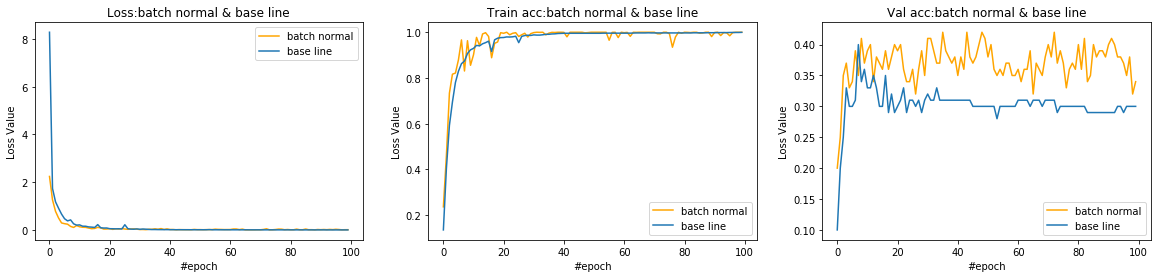

In [22]:
plot_(costs_bn,costs,cache_acc_train_bn,cache_acc_train,cache_acc_val_bn,cache_acc_val)

可以看到在小权重,大学习率下,baseline的波动性是较大的而BN是在一定范围内波动,而且BN的收敛速度快.

####  大权重,小学习率

In [29]:
bn_param,parameters_bn,L_bn,costs_bn,cache_acc_train_bn,cache_acc_val_bn = model(train_x,
                                                                                 train_y,
                                                                                 val_x,
                                                                                 val_y,
                                                                                 1000,[100, 80,50,30,10],
                                                                                 0.001,batch_size=32,is_small=False)

After epoch:0 loss:2.68798220834757 train acc:0.106 val acc:0.08
After epoch:100 loss:2.079574553446978 train acc:0.25 val acc:0.27
After epoch:200 loss:2.005569487516643 train acc:0.2895 val acc:0.25
After epoch:300 loss:2.000094044527318 train acc:0.3015 val acc:0.24
After epoch:400 loss:1.9745733380850705 train acc:0.3105 val acc:0.24
After epoch:500 loss:1.9631853513593587 train acc:0.3095 val acc:0.2
After epoch:600 loss:1.9686001287732438 train acc:0.3 val acc:0.23
After epoch:700 loss:1.9584105372712488 train acc:0.3055 val acc:0.25
After epoch:800 loss:1.9648628422384293 train acc:0.313 val acc:0.25
After epoch:900 loss:1.9604934764598843 train acc:0.308 val acc:0.24


In [30]:
parameters,costs, cache_acc_train, cache_acc_val,L = MODEL(train_x,train_y,
                                                           val_x,val_y,1000,
                                                         [100,80,50,30,10],0.001,batch_size=32,is_small=False)

After epoch:0 loss:nan train acc:0.101 val acc:0.07
After epoch:100 loss:nan train acc:0.101 val acc:0.07
After epoch:200 loss:nan train acc:0.101 val acc:0.07
After epoch:300 loss:nan train acc:0.101 val acc:0.07
After epoch:400 loss:nan train acc:0.101 val acc:0.07
After epoch:500 loss:nan train acc:0.101 val acc:0.07
After epoch:600 loss:nan train acc:0.101 val acc:0.07
After epoch:700 loss:nan train acc:0.101 val acc:0.07
After epoch:800 loss:nan train acc:0.101 val acc:0.07
After epoch:900 loss:nan train acc:0.101 val acc:0.07


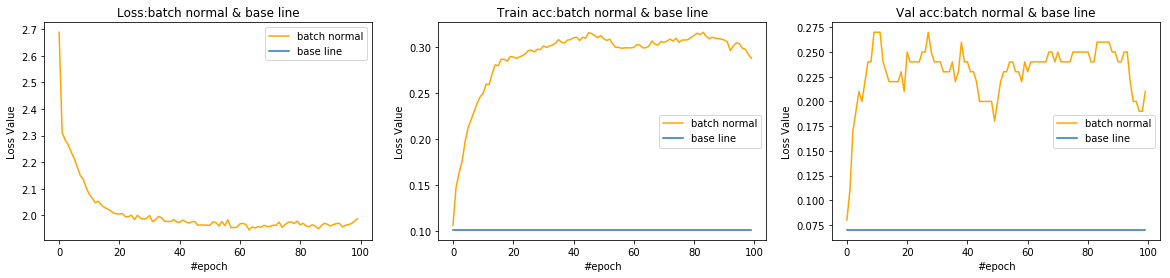

In [31]:
plot_(costs_bn,costs,cache_acc_train_bn,cache_acc_train,cache_acc_val_bn,cache_acc_val)

很明显,较大的初始化权重会直接导致baseline的失效,但是BN没有受到影响,但是整体正确率也在下滑.

#### 大权重,大学习率

In [26]:
bn_param,parameters_bn,L_bn,costs_bn,cache_acc_train_bn,cache_acc_val_bn = model(train_x,
                                                                                 train_y,
                                                                                 val_x,
                                                                                 val_y,
                                                                                 1000,[100, 80,50,30,10],
                                                                                 0.1,batch_size=60,is_small=False)

After epoch:0 loss:2.376915375612148 train acc:0.142 val acc:0.07
After epoch:100 loss:1.9413428712081382 train acc:0.326 val acc:0.25
After epoch:200 loss:1.8056164402545902 train acc:0.396 val acc:0.29
After epoch:300 loss:1.6158173389379218 train acc:0.459 val acc:0.3
After epoch:400 loss:1.4073769935166216 train acc:0.5395 val acc:0.27
After epoch:500 loss:1.1788761178828226 train acc:0.641 val acc:0.25
After epoch:600 loss:1.004890132206165 train acc:0.719 val acc:0.28
After epoch:700 loss:0.7951368438087506 train acc:0.8055 val acc:0.3
After epoch:800 loss:0.7100331740230111 train acc:0.8465 val acc:0.28
After epoch:900 loss:0.5839761947356805 train acc:0.901 val acc:0.29


In [27]:
parameters,costs, cache_acc_train, cache_acc_val,L = MODEL(train_x,train_y,
                                                           val_x,val_y,1000,
                                                         [100,80,50,30,10],0.1,batch_size=60,is_small=False)

After epoch:0 loss:nan train acc:0.101 val acc:0.07
After epoch:100 loss:nan train acc:0.101 val acc:0.07
After epoch:200 loss:nan train acc:0.101 val acc:0.07
After epoch:300 loss:nan train acc:0.101 val acc:0.07
After epoch:400 loss:nan train acc:0.101 val acc:0.07
After epoch:500 loss:nan train acc:0.101 val acc:0.07
After epoch:600 loss:nan train acc:0.101 val acc:0.07
After epoch:700 loss:nan train acc:0.101 val acc:0.07
After epoch:800 loss:nan train acc:0.101 val acc:0.07
After epoch:900 loss:nan train acc:0.101 val acc:0.07


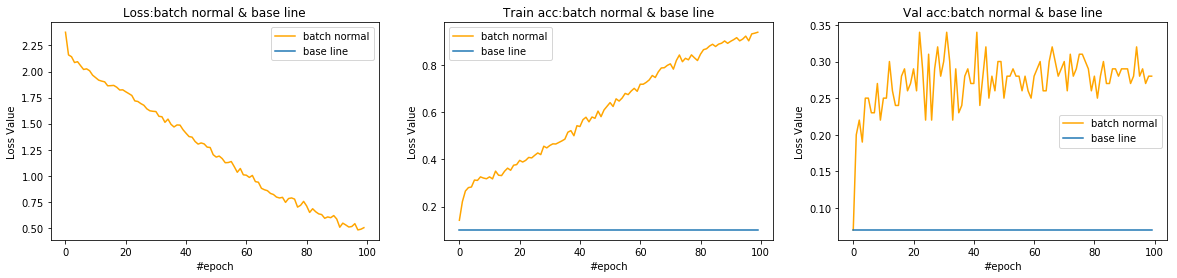

In [28]:
plot_(costs_bn,costs,cache_acc_train_bn,cache_acc_train,cache_acc_val_bn,cache_acc_val)

同样,baseline失效,BN的正确率还在处于一个上升阶段.

# Summary

总体而言BN效果会优于Baseline,且收敛速度较快,在极端初始值或者学习率的情况下,也能处理较好.